In [1]:
import pickle
import pandas as pd
import numpy as np

import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import itertools

from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score

from keras.models import load_model
from keras.utils import np_utils

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="0", 
        allow_growth=True
    )
)

set_session(tf.Session(config=config))

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# read data
df = pd.read_csv('../data/feature_selection_negative.csv', index_col=0)

# divide objective and target
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)
features = df.drop('Subclass', axis=1)

# train test split
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [3]:
d = {}

In [4]:
lgb_model = pickle.load(open('../model/LGBM_best_params_fs_neg.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [5]:
rf_model = pickle.load(open('../model/rf_gs_fs_neg.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

In [6]:
xgb_model = pickle.load(open('../model//xgb_fs_gs_neg.sav', 'rb'))
xgb_result = rf_model.predict_proba(X_test)
d['XGBoost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [7]:
keras_model  = load_model('../model/Keras_best_params_neg_fs.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [8]:
o = {}

In [9]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [10]:
b = pd.DataFrame()
b = pd.concat([b, pd.DataFrame(d).T], axis=1)

In [11]:
v = pd.DataFrame()
v = pd.concat([v, pd.DataFrame(o).T], axis=1)

In [12]:
# read data
df = pd.concat([
    pd.read_csv('../data/feature_selection_negative.csv', index_col=0),
    pd.read_csv('../data/decomp_neg.csv', index_col=0).drop('Subclass', axis=1)
], axis=1)

# divide objective and target
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)
features = df.drop('Subclass', axis=1)

# train test split
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [13]:
d = {}

In [14]:
lgb_model = pickle.load(open('../model/LGBM_best_params_fs_deco_neg.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [15]:
xgb_model = pickle.load(open('../model/xgb_fs_deco_neg.sav', 'rb'))
xgb_result = xgb_model.predict_proba(X_test)
d['XGBoost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
rf_model = pickle.load(open('../model/rf_gs_fs_deco_neg.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

In [17]:
keras_model  = load_model('../model/Keras_best_params_neg_dec.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [18]:
o = {}

In [19]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [20]:
b = pd.concat([b, pd.DataFrame(d).T], axis=1)
v = pd.concat([v, pd.DataFrame(o).T], axis=1)

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [21]:
t = pd.concat([b, v])
t.columns = ['Feature_Selection_Negative', 'Feature Selection + Decomposition_Negative']

In [22]:
t.sort_values('Feature Selection + Decomposition_Negative', ascending=False)
# .to_csv('../result/voting_gs_neg.csv')

,Feature_Selection_Negative,Feature Selection + Decomposition_Negative
XGBoost + Random Forest + LightGBM + Keras,74.47,77.66
XGBoost + Ramdom Forest,63.83,76.60
Random Forest + LightGBM,74.47,76.60
XGBoost + LightGBM + Keras,74.47,76.60
XGBoost + Random Forest + LightGBM,73.40,75.53
XGBoost + Random Forest + Keras,73.40,75.53
Random Forest + LightGBM + Keras,74.47,75.53
LightGBM,76.60,74.47
XGBoost,75.53,74.47
XGBoost + LightGBM,74.47,74.47


In [23]:
y_pred = np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1)

### Best Accuracy score's detail

In [24]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=16)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

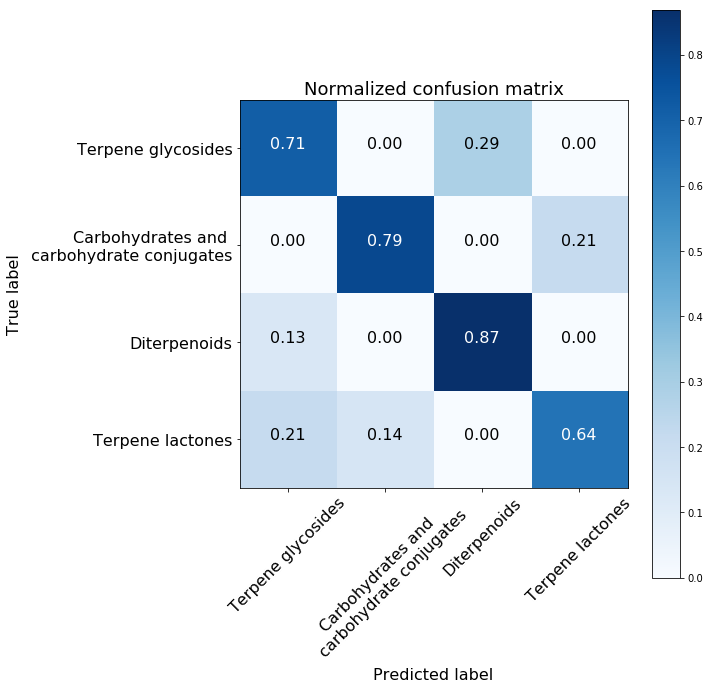

In [25]:
# set name list
class_names = list(df.Subclass.value_counts().index)
class_names[1] = 'Carbohydrates and \n carbohydrate conjugates'
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [26]:
print('Accuracy: '+str(accuracy_score(y_test, y_pred)))

print('Precision(micro): '+str(precision_score(y_test, y_pred, average='micro')))
print('Recall(micro): '+str(recall_score(y_test, y_pred, average='micro')))
print('F1(micro): '+str(f1_score(y_test, y_pred, average='micro')))

print('Precision(macro): '+str(precision_score(y_test, y_pred, average='macro')))
print('Recall(macro): '+str(recall_score(y_test, y_pred, average='macro')))
print('F1(macro): '+str(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.776595744680851
Precision(micro): 0.776595744680851
Recall(micro): 0.776595744680851
F1(micro): 0.776595744680851
Precision(macro): 0.7788294023050121
Recall(macro): 0.7528195488721804
F1(macro): 0.7642128148457263
